[link text](https://)# Synthesis mode classification for Heavy Ion Collisions for diffrent dataset size and K-Folding

**Authors:** [Haydar Mehryar](https://github.com/hmehryar) <br>
**Date created:** 2023/12/01<br>
**Last modified:** 2020/12/20<br>
**Description:** Implementation of Simple Deep NEtwork for heavy ion colllisions classifiction

In [1]:
import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))
print (tf.__version__)
print(len(tf.config.experimental.list_physical_devices('GPU'))>0)
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


2.15.0
False


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
import sys
sys.path.insert(1,'/wsu/home/gy/gy40/gy4065/hm.jetscapeml.source')
sys.path.insert(1,'/content/drive/My Drive/Projects/110_JetscapeMl/hm.jetscapeml.source')
sys.path.insert(1,'/g/My Drive/Projects/110_JetscapeMl/hm.jetscapeml.source')
sys.path.insert(1,'G:\\My Drive\\Projects\\110_JetscapeMl\\hm.jetscapeml.source')

In [41]:
# loading libraries
print('Loading/Installing Package => Begin\n\n')
import jet_ml_dataset_builder.jet_ml_dataset_builder_utilities as util
from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import set_directory_paths
from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import parse_parameters
from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import load_dataset
from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import install

import os
from time import time
import glob

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint,History,TensorBoard
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import json
%matplotlib inline

tf.random.set_seed(1234)
print('\nLoading/Installing Package => End\n\n')


Loading/Installing Package => Begin



Loading/Installing Package => End




In [4]:
print('\n########################################################################')
print('Checking the running platforms\n')

# Call the function and retrieve the dataset_directory_path and simulation_directory_path
dataset_directory_path, simulation_directory_path = set_directory_paths()

# Access the dataset_directory_path and simulation_directory_path
print("Dataset Directory Path:", dataset_directory_path)
print("Simulation Directory Path:", simulation_directory_path)
print('########################################################################\n')


########################################################################
Checking the running platforms

Python version: 3.11.5
OS: Windows
OS version: 10
running on Colab: False
Dataset Directory Path: G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\
Simulation Results Path: G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\
Dataset Directory Path: G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\
Simulation Directory Path: G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\
########################################################################



In [5]:
# Call the function and retrieve the tokenized parameters
tokenized_arguments, tokenized_values = parse_parameters()

# Access the tokenized arguments and values
print("Tokenized Arguments:")
for argument in tokenized_arguments:
    print(argument)

print("\nTokenized Values:")
for argument, value in tokenized_values.items():
    print(f"{argument}: {value}")

y_class_label_items=['MMAT','MLBT']
alpha_s_items=[0.2 ,0.3 ,0.4]
q0_items=[1.5 ,2.0 ,2.5]

print("y_class_label_items:",y_class_label_items)
print("alpha_s_items:",alpha_s_items)
print("q0_items:",q0_items)

option --f not recognized
Tokenized Arguments:

Tokenized Values:
y_class_label_items: ['MMAT', 'MLBT']
alpha_s_items: [0.2, 0.3, 0.4]
q0_items: [1.5, 2.0, 2.5]


In [6]:
print("Building required params for the loading the dataset file")

class_labels_str = '_'.join(y_class_label_items)
alpha_s_items_str='_'.join(map(str, alpha_s_items))
q0_items_str='_'.join(map(str, q0_items))
total_size=9*1200000

Building required params for the loading the dataset file


In [7]:
# loading dataset by size and getting just the first column
# Function to load datasets of different sizes
def get_dataset(size):
    dataset_file_name = f"jet_ml_benchmark_config_01_to_09_alpha_{alpha_s_items_str}_q0_{q0_items_str}_{class_labels_str}_size_{size}_shuffled.pkl"

    dataset_file_name=simulation_directory_path+dataset_file_name
    print("dataset_file_name:",dataset_file_name)

    dataset=load_dataset(dataset_file_name,has_test=False)
    (dataset_x, dataset_y) = dataset
    print('Extract the first column for binary classification')
    # dataset_y = dataset_y[:, 0]
    print("dataset.x:",type(dataset_x), dataset_x.size, dataset_x.shape)
    print("dataset.y:",type(dataset_y), dataset_y.size,dataset_y.shape)
    return dataset_x, dataset_y

Building and Compiling the Classifier model

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_eloss_classifier_model(input_shape,num_of_classes):
    # Define the model for eloss prediction
    eloss_model = models.Sequential([
        layers.Flatten(input_shape=input_shape),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(2, activation='sigmoid')  # Assuming two classes: 'MMAT' and 'MLBT'
    ],name="eloss_net")    
    return eloss_model

def build_alpha_s_classifier_model(input_shape,num_of_classes):
    # Repeat the same process for alpha_s prediction
    alpha_s_model = models.Sequential([
        layers.Flatten(input_shape=input_shape),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(3, activation='softmax')  # Assuming three classes: 0.2, 0.3, 0.4
    ],name="alpha_s_net")
    return alpha_s_model

def build_q_0_classifier_model(input_shape, num_of_classes):
    # Repeat for the third column
    q_0_model = models.Sequential([
        layers.Flatten(input_shape=input_shape),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(4, activation='softmax')  # Assuming four classes for the third column
    ],name="q_0_net")
    return q_0_model

In [9]:
# Assuming 'input_shape' is the shape of each input in dataset.x (e.g., (32, 32))
input_shape=(32,32)
eloss_net=build_eloss_classifier_model(input_shape,num_of_classes=2)
alpha_s_net=build_alpha_s_classifier_model(input_shape,num_of_classes=3)
q_0_net=build_q_0_classifier_model(input_shape,num_of_classes=4)
learning_rate=0.001

In [10]:
#ToDo a better implementation which include learning rate
# optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# model.compile(
#     # loss="sparse_categorical_crossentropy",
#     loss="binary_crossentropy",
#     optimizer=optimizer,
#     # metrics=["sparse_categorical_accuracy"],
#     metrics=["accuracy"],
# )
  
def compile_eloss_classifier_model_with_hyperparam(model,learning_rate):
  model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
  model.summary()
  return model
def compile_alpha_s_classifier_model_with_hyperparam(model,learning_rate):
  model.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])
  model.summary()
  return model
def compile_q_0_classifier_model_with_hyperparam(model,learning_rate):
  model.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])
  model.summary()
  return model

In [11]:
eloss_net=compile_eloss_classifier_model_with_hyperparam(eloss_net,learning_rate)
alpha_s_net=compile_alpha_s_classifier_model_with_hyperparam(alpha_s_net,learning_rate)
q_0_net=compile_q_0_classifier_model_with_hyperparam(q_0_net,learning_rate)



Model: "eloss_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 64)                65600     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 67746 (264.63 KB)
Trainable params: 67746 (264.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "alpha_s_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param # 

In [12]:
tf.keras.utils.plot_model(eloss_net, show_shapes=True)
tf.keras.utils.plot_model(alpha_s_net, show_shapes=True)
tf.keras.utils.plot_model(q_0_net, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [13]:
def split_dataset(dataset_x, dataset_y, test_size=0.2, random_state=None):
    """
    Split the dataset into training and testing sets.

    Parameters:
    - dataset_x: The input data (3D array).
    - dataset_y: The target values (2D array).
    - test_size: The proportion of the dataset to include in the test split.
    - random_state: Seed for random number generation.

    Returns:
    - x_train, x_test: The split input data for training and testing.
    - y_train, y_test: The split target values for training and testing.
    """
    # Flatten the input data to 2D
    flattened_dataset_x = dataset_x.reshape(dataset_x.shape[0], -1)

    # Split the dataset
    x_train, x_test,  y_train, y_test = \
        train_test_split(flattened_dataset_x, dataset_y, test_size=test_size, random_state=random_state)

    # Reshape the input data back to 3D
    x_train = x_train.reshape(x_train.shape[0], dataset_x.shape[1], dataset_x.shape[2])
    x_test = x_test.reshape(x_test.shape[0], dataset_x.shape[1], dataset_x.shape[2])

    return x_train, x_test, y_train, y_test

In [14]:
def parse_dataset(x_train,x_test):
    train_labels = []
    test_labels = []
    i=0
    for f in x_train:

        train_labels.append(i)
        i=i+1
    for f in x_test:
        test_labels.append(i)
        i=i+1
    return (
        np.array(train_labels),
        np.array(test_labels),
    )

In [15]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label

In [16]:
def evaluate_model(model, x_test, y_test, is_binary_classification=False):
    """
    Evaluate the performance of a trained model on test data.

    Parameters:
    - model: The trained deep neural model.
    - x_test: Test data, it shall be in the flatten format, each entry contains 1024x1 data.
    - y_test: True labels.

    Returns:
    - accuracy: Accuracy of the model on the test data.
    - confusion_matrix: Confusion matrix for the predictions.
    """
    # Assuming model is your trained deep neural model
    y_pred = model.predict(x_test)
    print("y_pred",y_pred)
    y_pred_class = np.argmax(y_pred, axis=1)  # Extracting the class with the highest probability

    if is_binary_classification:
        # Assuming y_true is a Nx2 array where each row contains the true class probabilities
        y_true_class = np.argmax(y_test, axis=1)  # Extracting the class with the highest true probability
        accuracy = accuracy_score(y_true_class, y_pred_class)
        cm = confusion_matrix(y_true_class, y_pred_class)
    else:
        accuracy=accuracy_score(y_test,y_pred_class)
        cm = confusion_matrix(y_test, y_pred_class)
    
    print(f'Accuracy: {accuracy}')
    print(f'Confusion Matrix: {cm}')

    return accuracy, cm

# Example usage:
# accuracy, confusion_matrix = evaluate_model(trained_model, test_data, true_labels)


In [17]:
def preprocess_y_eloss(y_train,y_test):
    # One-hot encode the categorical variable for eloss
    # print(y_train)
    y_train_0_categorical = np.array(y_train).reshape(-1, 1)
    y_test_0_categorical = np.array(y_test).reshape(-1, 1)

    encoder = OneHotEncoder(sparse_output=False)
    y_train_0_categorical_encoded = encoder.fit_transform(y_train_0_categorical)
    y_test_0_categorical_encoded = encoder.transform(y_test_0_categorical)
    return y_train_0_categorical_encoded,y_test_0_categorical_encoded

def convert_y_to_float(y_train,y_test):
    y_train = y_train.astype(np.float32)
    y_test= y_test.astype(np.float32)
    return y_train,y_test

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
def convert_y_to_integer_categorical(y_train,y_test):
    # Step 1: Convert string labels to integer labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded= label_encoder.fit_transform(y_test)
    num_classes = len(label_encoder.classes_)
    return y_train_encoded,y_test_encoded, num_classes

def convert_y_to_categorical(y_train,y_test):
    # # Step 1: Convert string labels to integer labels
    # label_encoder = LabelEncoder()
    # y_train_encoded = label_encoder.fit_transform(y_train)
    # y_test_encoded= label_encoder.fit_transform(y_test)
    y_train_encoded,y_test_encoded,num_classes=convert_y_to_integer_categorical(y_train,y_test)
    # Step 2: Convert integer labels to one-hot encoded format
    # num_classes = len(label_encoder.classes_)
    y_train_categorical = to_categorical(y_train_encoded, num_classes=num_classes)
    y_test_categorical = to_categorical(y_test_encoded, num_classes=num_classes)

    return y_train_categorical,y_test_categorical



def preprocess_y_alpha_s(y_train,y_test):
    y_train_categorical,y_test_categorical,num_classes =convert_y_to_integer_categorical(y_train,y_test)
    return y_train_categorical,y_test_categorical

def preprocess_y_q_0(y_train,y_test):
    y_train_categorical,y_test_categorical,num_classes =convert_y_to_integer_categorical(y_train,y_test)
    return y_train_categorical,y_test_categorical

In [18]:
def preprocess_dataset(dataset_x, dataset_y):
  print("Pre-processing")
  # Example usage:
  x_train, x_test, y_train, y_test= \
    split_dataset(dataset_x, dataset_y, test_size=0.2, random_state=None)
  print("deleting the original dataset after splitting ...")
  del dataset_x,dataset_y
  
  print("x_train:",type(x_train), x_train.size, x_train.shape)
  print("y_train:",type(y_train), y_train.size,y_train.shape)

  print("x_test:",type(x_test), x_test.size, x_test.shape)
  print("y_test:",type(y_test), y_test.size,y_test.shape)
  
  # train_labels, test_labels = parse_dataset(x_train,x_test)
  # print(train_labels.size,test_labels.size)

  # BATCH_SIZE = 32

  # train_dataset = train_dataset.shuffle(len(x_train)).map(augment).batch(BATCH_SIZE)
  # test_dataset = test_dataset.shuffle(len(x_test)).batch(BATCH_SIZE)

  print("Preprocess y_train and y_test")
  y_train_eloss, y_test_eloss,y_train_alpha_s, y_test_alpha_s,y_train_q_0, y_test_q_0=([],[],[],[],[],[])

  
  print("y_train[:,0]:",type(y_train[:,0]), y_train[:,0].size,y_train[:,0].shape)
  y_train_eloss, y_test_eloss=preprocess_y_eloss(y_train[:,0],y_test[:,0])
  print(y_train[:4,0])
  print(y_train_eloss[:4])

  print("y_train[:,1]:",type(y_train[:,1]), y_train[:,1].size,y_train[:,1].shape)
  y_train_alpha_s, y_test_alpha_s=preprocess_y_alpha_s(y_train[:,1],y_test[:,1])
  print(y_train[:4,1])
  print(y_train_alpha_s[:4])

  print("y_train[:,2]:",type(y_train[:,2]), y_train[:,2].size,y_train[:,2].shape)
  y_train_q_0, y_test_q_0=preprocess_y_q_0(y_train[:,2],y_test[:,2])
  print(y_train[:4,1])
  print(y_train_alpha_s[:4])

  return (x_train, y_train_eloss,y_train_alpha_s,y_train_q_0, \
          x_test, y_test_eloss,y_test_alpha_s,y_test_q_0)
# (dataset_x, dataset_y)= get_dataset(1000)
# (x_train, y_train_eloss,y_train_alpha_s,y_train_q_0, \
#   x_test, y_test_eloss,y_test_alpha_s,y_test_q_0)=\
# preprocess_dataset(dataset_x, dataset_y)

In [19]:
def plot_training_history(history,simulation_path):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    # Set ticks on the epoch axis to display only integer values
    plt.xticks(range(0, len(history.history['accuracy'])+1,5))

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Set ticks on the epoch axis to display only integer values
    plt.xticks(range(0, len(history.history['accuracy'])+1,5))

    # Adjust layout and show the plot
    plt.tight_layout()


    # Save the plot with high resolution (300 dpi)
    file_name='_accuracy_loss.png'
    file_path=simulation_path+file_name
    plt.savefig(file_path, dpi=300)
    plt.show()
    plt.close()
    return file_path

# Plot the training history
# plot_training_history_path=plot_training_history(history,simulation_path)

In [20]:
def save_training_history(history,simulation_path):
  # Save the training history to a file (e.g., JSON format)

  training_history_file_path =simulation_path+'_training_history'
  # training_history_file_path  =simulation_directory_path+training_history_file_name

  training_history_file_path_json=training_history_file_path+'.json'
  with open(training_history_file_path_json, 'w') as f:
      json.dump(history.history, f)
  print(training_history_file_path_json)

  training_history_file_path_csv=training_history_file_path+'.csv'
  pd.DataFrame.from_dict(history.history).to_csv(training_history_file_path_csv,index=False)
  print(training_history_file_path_csv)

  training_history_file_path_npy=training_history_file_path+'.npy'
  np.save(training_history_file_path_npy,history.history)
  print(training_history_file_path_npy)
  return training_history_file_path_json,training_history_file_path_csv,training_history_file_path_csv

# training_history_file_path_json,training_history_file_path_csv,training_history_file_path_csv = \
#   save_training_history(history,simulation_path)

In [43]:
# train and evaluate classifiers
# This method shall get the cloud points as the trainset, to be trained by pointnet

from tensorflow.keras.callbacks import ModelCheckpoint, History, TensorBoard

def train_and_evaluate_classifier_kfold(model, x_train,y_train , x_test, y_test, n_epochs, monitor, k_folds,simulation_path,is_binary_classification):

    # Use KFold for k-fold cross-validation
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    accuracies = []
    cms = []
    train_times = []
    all_histories = []  # Store histories for each fold
    plots=[]
    models=[]
    for fold, (train_index, val_index) in enumerate(kfold.split(x_train)):
    # train_index, val_index in kfold.split(x_train):
        x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Include both ModelCheckpoint and History callbacks in the callbacks list
        # callbacks=[checkpoint_callback]
        fold_path=f'{simulation_path}_fold_{fold}'
        # Use ModelCheckpoint callback to save the best model
        best_model_file_path = f'{fold_path}_best_model.keras'

        models.append(best_model_file_path)
        checkpoint_callback = ModelCheckpoint(
            best_model_file_path,
            monitor=monitor,
            save_best_only=True,
            mode="max" if monitor == "val_accuracy" else "min",
            verbose=1
        )

        # Use History callback to retrieve the training history
        history_callback = History()
        log_dir=f'{simulation_path}/'
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

        start = time()
        history = model.fit(
            x_train_fold,
            y_train_fold,
            epochs=n_epochs,
            validation_data=(x_val_fold, y_val_fold),
            callbacks=[checkpoint_callback,history_callback
                       ,tensorboard_callback
                       ]
        )
        train_time = (time()-start)/60.0
        train_times.append(train_time)
        # Append history to the list
        all_histories.append(history.history)

        plot=plot_training_history(history,fold_path)
        training_history_file_path_json,training_history_file_path_csv,training_history_file_path_csv = \
         save_training_history(history,fold_path)
        plots.append(plot)

        accuracy, confusion_matrix = evaluate_model(model, x_test, y_test,is_binary_classification)
        accuracies.append(accuracy)
        cms.append(confusion_matrix)

    return accuracies, cms, train_times, all_histories, plots,models

In [22]:
# Load the DataFrame from the saved file
def load_csv_into_dataframe(file_path):
  df_results = pd.read_csv(file_path, sep='\t')
  return df_results
#example usage
# df_results=load_csv_into_dataframe("/content/drive/MyDrive/Colab Notebooks/binary_classification_results_kfold_errorbar.txt")

In [23]:
def plot_save_mean_error_bar(df_results,simulation_path):
    # df_results= df_results_kfold_errorbar
    print(df_results)
    # Set a seaborn style (optional)
    sns.set(style="whitegrid")
    


    # Define a dictionary to map classifiers to markers
    marker_dict = {

        'ElossNet': 'o',
        'AlphaSNet': 's',
        'Q0Net': '^'
    }
    plt.figure(figsize=(10, 6))

    for clf_name, group in df_results.groupby('Classifier'):
        plt.errorbar(
            group['Dataset_Size'],
            group['Mean_Accuracy'],
            yerr=group['Std_Accuracy'],
            label=clf_name,
            marker=marker_dict.get(clf_name, 'o'),  # Use 'o' as default marker if not found in the dictionary
            capsize=5
        )

    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.xlabel('Dataset Size (log scale)')
    plt.ylabel('Mean Accuracy')
    plt.title('Energy loss, alpha_s, and Q_0 Classification Accuracy with Error Bars for Different Dataset Sizes')
    plt.legend()
    # plt.grid(True)
    # Save the plot with high resolution (300 dpi)
    accuracy_errorbar_plot_path=simulation_path+'_results_accuracy_errorbar_plot.png'
    plt.savefig(accuracy_errorbar_plot_path, dpi=300)
    plt.show()

In [24]:
def train_and_evaluate_classifier_for_all_datasets(dataset_sizes,classifiers,simulation_path,n_epochs, monitor, k_folds):
  print(simulation_path)
  # Results storage
  results_kfold = []
  results_kfold_errorbar=[]
  # Loop through different dataset sizes
  for size in dataset_sizes:
      current_simulation_name=f'_size_{size}'
      current_simulation_path=simulation_path+current_simulation_name
      print(current_simulation_path)
      # Generate dataset
      # x, y = get_dataset(size)
      (dataset_x, dataset_y)= get_dataset(size)
      (x_train, y_train_eloss,y_train_alpha_s,y_train_q_0, \
       x_test, y_test_eloss,y_test_alpha_s,y_test_q_0)=\
        preprocess_dataset(dataset_x, dataset_y)

      # Loop through classifiers
      for clf_name, clf in classifiers.items():
        current_classifier_name=f'_classifier_{clf_name}'
        current_simulation_path_with_classifier=current_simulation_path+current_classifier_name
        print(current_simulation_path_with_classifier)
        is_binary_classification=False
        # Choose the appropriate y_train and y_test based on clf_name
        if clf_name == 'ElossNet':
            y_train, y_test = y_train_eloss, y_test_eloss
            is_binary_classification=True
        elif clf_name == 'AlphaSNet':
            y_train, y_test = y_train_alpha_s, y_test_alpha_s
        elif clf_name == 'Q0Net':
            y_train, y_test = y_train_q_0, y_test_q_0
        else:
            raise ValueError(f"Unknown classifier name: {clf_name}")
        # print("y_trian",y_train[:10])
        # print("y_test",y_test[:10])
        # Evaluate classifier using k-fold cross-validation
        fold_accuracies, fold_conf_matrices, fold_train_times, all_histories, plots, models = \
        train_and_evaluate_classifier_kfold(clf, x_train,  y_train,x_test,  y_test, n_epochs, monitor, k_folds,current_simulation_path_with_classifier,is_binary_classification )

        # Store results for each fold
        for fold_num, (accuracy, cm,train_time,plot,model) in enumerate(zip(fold_accuracies, fold_conf_matrices,fold_train_times,plots,models), start=1):
            results_kfold.append({
                'Dataset Size': size,
                'Classifier': clf_name,
                'Fold Number': fold_num,
                'Accuracy': accuracy,
                'Confusion Matrix': cm,
                'Train Time': train_time,
                'Loss/Accuracy Plot Path': plot,
                'Best Model Path': model
            })
            print(f'Average Train Time: {np.mean(fold_train_times)} minutes')
            # Calculate mean and standard deviation of accuracy scores
            mean_accuracy = np.mean(fold_accuracies)
            std_accuracy = np.std(fold_accuracies)

            # Store results
            results_kfold_errorbar.append({
                'Dataset_Size': size,
                'Classifier': clf_name,
                'Mean_Accuracy': mean_accuracy,
                'Std_Accuracy': std_accuracy
            })
  # Create a DataFrame from k-fold results
  df_results_kfold = pd.DataFrame(results_kfold)
  # Save the DataFrame to a text file
  results_kfold_path=simulation_path+'_results_kfold.txt'
  df_results_kfold.to_csv(results_kfold_path, index=False, sep='\t')
  # Display results in a table
  print(df_results_kfold)

  # Create a DataFrame from k-fold results
  df_results_kfold_errorbar = pd.DataFrame(results_kfold_errorbar)
  # Save the DataFrame to a text file
  results_kfold_errorbar_path=simulation_path+'_results_kfold_errorbar.txt'
  df_results_kfold_errorbar.to_csv(results_kfold_errorbar_path, index=False, sep='\t')
  # Display results in a table
  print(df_results_kfold_errorbar)
  plot_save_mean_error_bar(df_results_kfold_errorbar,simulation_path)

In [25]:
# Classifiers 'ElossNet','AlphaSNet','Q0Net'
classifiers = {
    'ElossNet': eloss_net,
    'AlphaSNet':alpha_s_net,
    'Q0Net':q_0_net
}

G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\
G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification
G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000
dataset_file_name: G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_shuffled.pkl
dataset.x: <class 'numpy.ndarray'> 1024000 (1000, 32, 32)
dataset.y: <class 'numpy.ndarray'> 3000 (1000, 3)
Extract the first column for binary classification
dataset.x: <class 'numpy.ndarray'> 1024000 (1000, 32, 32)
dataset.y: <class 'numpy.ndarray'> 3000 (1000, 3)
Pre-processing
deleting the original dataset after splitting ...
x_train: <class 'numpy.ndarray'> 819200 (800, 32, 32)
y_train: <class 'numpy.ndarray'> 2400 (800, 3)
x_test: <class 'numpy.ndarray'> 204800 (200, 32, 32)
y_test: <class 'numpy.ndarray'> 600 (200, 3)
Pr

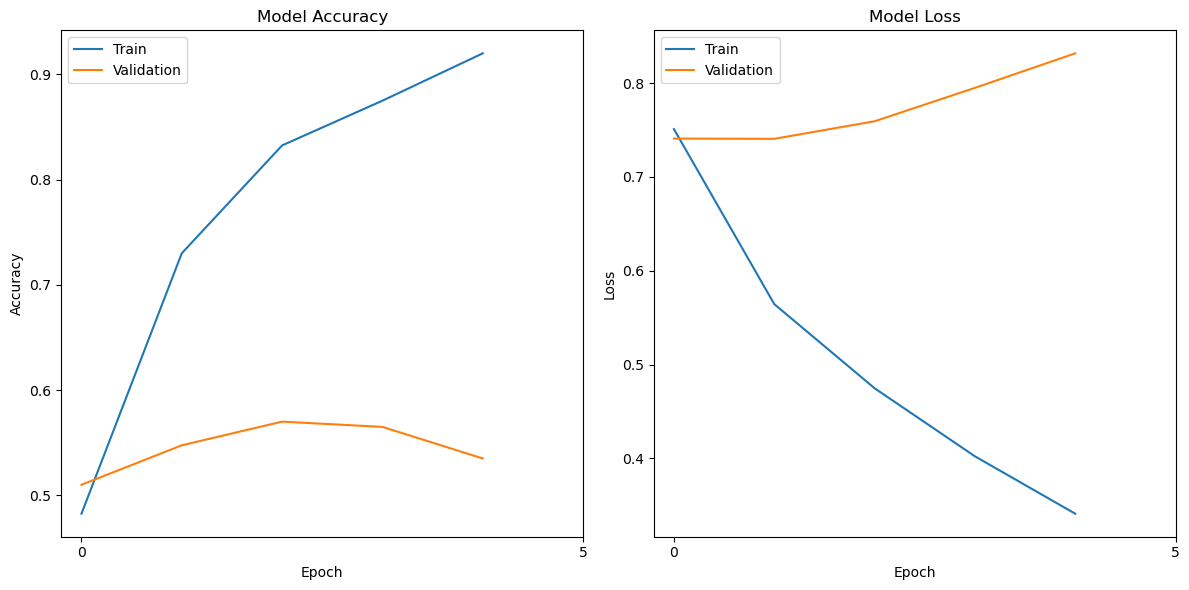

G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossNet_fold_0_training_history.json
G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossNet_fold_0_training_history.csv
G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossNet_fold_0_training_history.npy
7/7 [==============================] - 0s 2ms/step
y_pred [[0.5771313  0.39730823]
 [0.5756565  0.47723776]
 [0.5797738  0.27501494]
 [0.6006661  0.6548821 ]
 [0.6901133  0.3063974 ]
 [0.8295301  0.41146356]
 [0.50231147 0.39916492]
 [0.048193   0.9340544 ]
 [0.56490624 0.4663487 ]
 [0.7014072  0.2790331 ]
 [0.35211506 0.9072906 ]
 [0.69905955 0.24968666]
 [0.16950375 0.8777363 ]
 [0.6934226  0.58353794]
 [0.16055465 0.79442817]
 [0.48180234 0.48170367]
 [0.29754186 0.83175534]
 [0.7126406  0.25722006]
 [0.43792734 0.49712968]
 [0.304

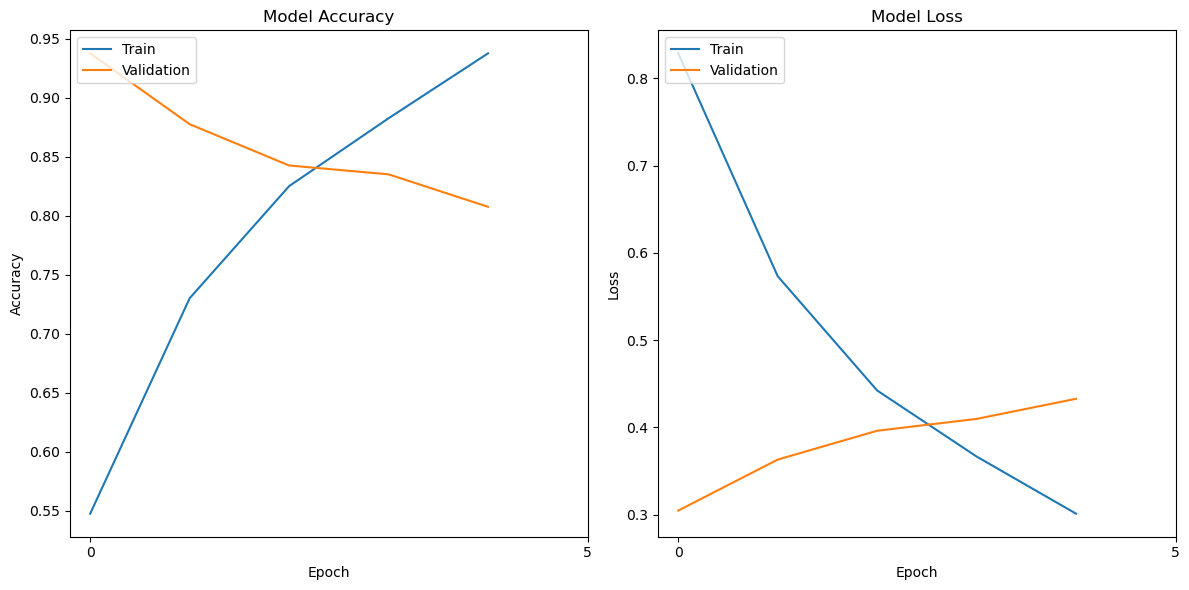

G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossNet_fold_1_training_history.json
G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossNet_fold_1_training_history.csv
G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossNet_fold_1_training_history.npy
7/7 [==============================] - 0s 2ms/step
y_pred [[0.4829278  0.5246117 ]
 [0.5015437  0.5265343 ]
 [0.19397649 0.72785777]
 [0.7979729  0.38473216]
 [0.8327264  0.18331154]
 [0.67571443 0.47312608]
 [0.20186055 0.8039876 ]
 [0.00262345 0.9975157 ]
 [0.05207659 0.9433866 ]
 [0.5155631  0.5794276 ]
 [0.29674566 0.91840714]
 [0.78377366 0.27530223]
 [0.40491855 0.6972939 ]
 [0.55028003 0.5613515 ]
 [0.48776162 0.39497256]
 [0.42834264 0.5956017 ]
 [0.0389794  0.9605994 ]
 [0.60238516 0.33039457]
 [0.56704515 0.30233112]
 [0.075

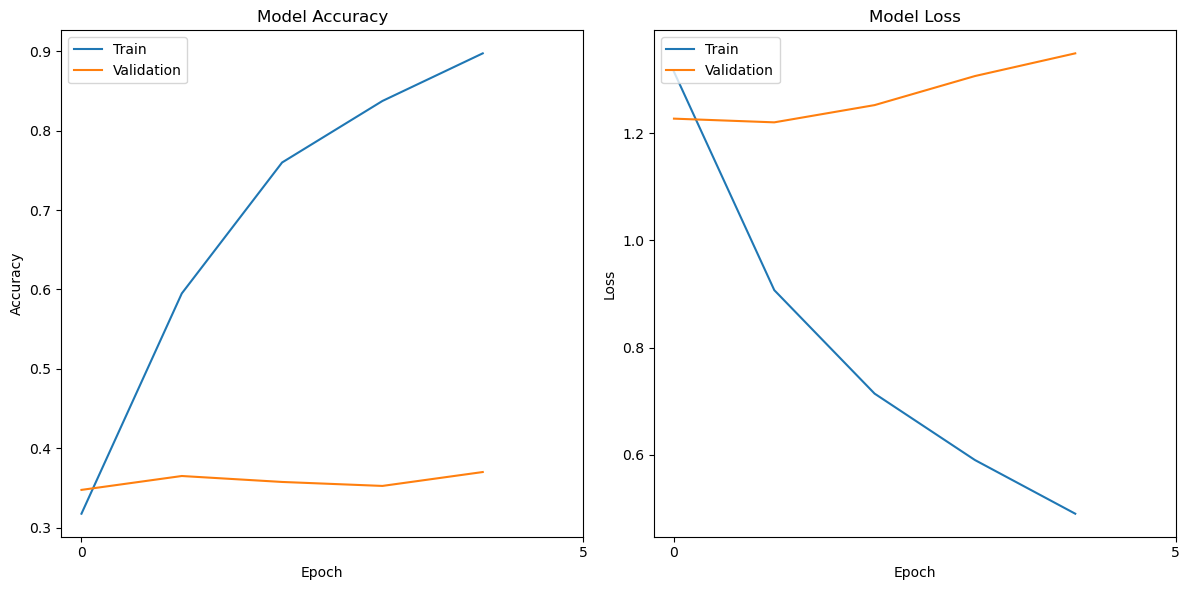

G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSNet_fold_0_training_history.json
G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSNet_fold_0_training_history.csv
G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSNet_fold_0_training_history.npy
7/7 [==============================] - 0s 2ms/step
y_pred [[0.18687077 0.3084017  0.5047275 ]
 [0.24758774 0.4449385  0.3074738 ]
 [0.13026069 0.10922613 0.7605132 ]
 [0.47406524 0.3794205  0.14651428]
 [0.31700814 0.38773644 0.2952554 ]
 [0.1547172  0.80586606 0.03941678]
 [0.06540504 0.6296868  0.30490813]
 [0.08677045 0.02980804 0.88342154]
 [0.26980424 0.6974988  0.03269697]
 [0.47443148 0.18515256 0.34041598]
 [0.15469144 0.4960901  0.34921837]
 [0.3749969  0.1662647  0.45873836]
 [0.04242238 0.5331162  0.42446136]
 [0.0023908

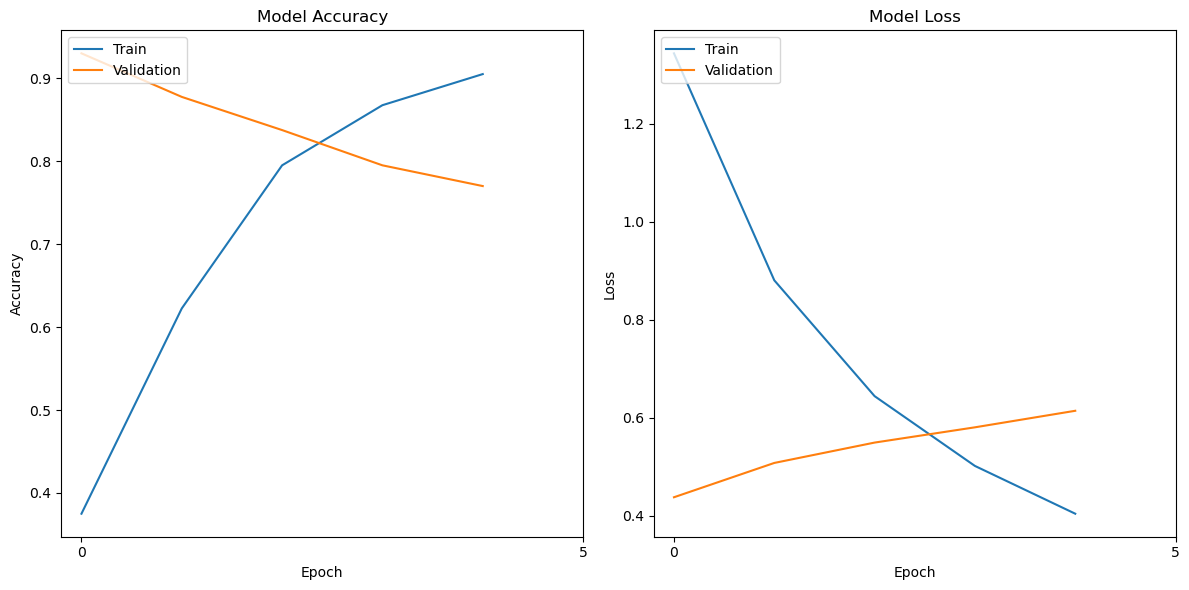

G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSNet_fold_1_training_history.json
G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSNet_fold_1_training_history.csv
G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSNet_fold_1_training_history.npy
7/7 [==============================] - 0s 2ms/step
y_pred [[1.54027686e-01 3.04955900e-01 5.41016400e-01]
 [9.54844430e-02 3.06199044e-01 5.98316610e-01]
 [1.28137723e-01 3.87572676e-01 4.84289557e-01]
 [1.63416281e-01 6.17341757e-01 2.19241947e-01]
 [2.37321436e-01 3.56164992e-01 4.06513602e-01]
 [1.27510978e-02 6.54291987e-01 3.32956910e-01]
 [9.74576473e-02 2.97353178e-01 6.05189145e-01]
 [1.39513658e-02 6.49606518e-04 9.85399008e-01]
 [3.04178119e-01 4.53616828e-01 2.42205098e-01]
 [2.61667490e-01 2.30168149e-01 5.08164346e-01]

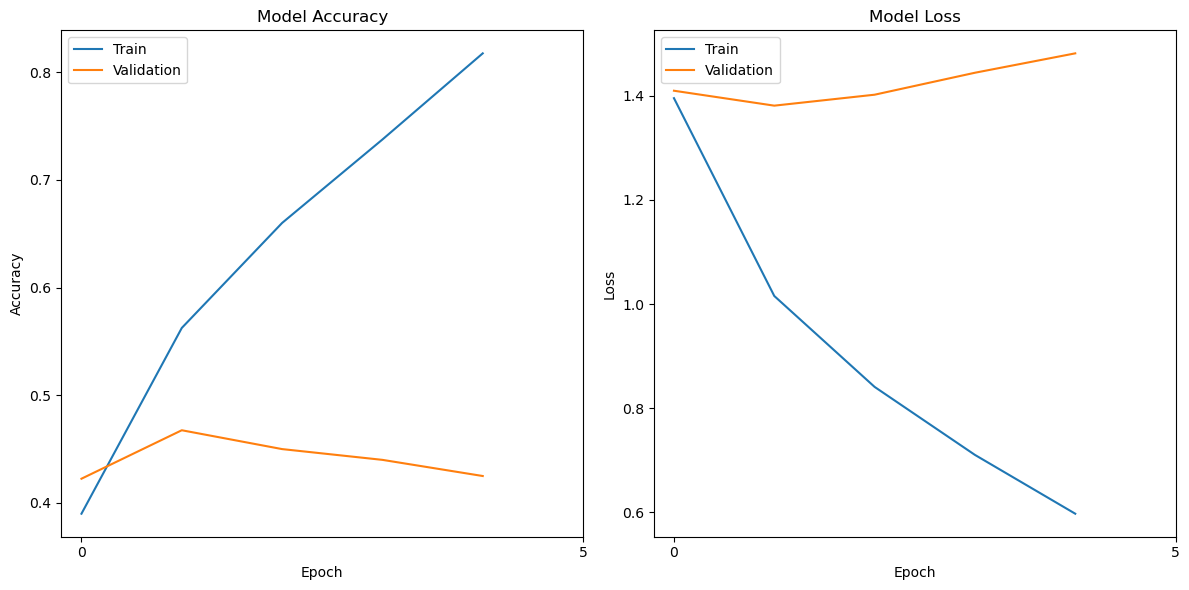

G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0Net_fold_0_training_history.json
G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0Net_fold_0_training_history.csv
G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0Net_fold_0_training_history.npy
7/7 [==============================] - 0s 2ms/step
y_pred [[2.53194124e-01 2.55370110e-01 2.05692112e-01 2.85743654e-01]
 [2.75994986e-01 3.12158674e-01 1.69851750e-01 2.41994619e-01]
 [8.40172648e-01 4.43005264e-02 8.52330551e-02 3.02936975e-02]
 [8.72578025e-01 1.56373829e-02 1.03987060e-01 7.79760676e-03]
 [3.01076591e-01 1.41959742e-01 1.87316492e-01 3.69647205e-01]
 [3.28197956e-01 3.49637032e-01 2.68122107e-01 5.40428236e-02]
 [8.27802360e-01 8.44988599e-02 4.67563905e-02 4.09424268e-02]
 [9.35143530e-01 6.66303979e-03 4.33678403e-02 1.4

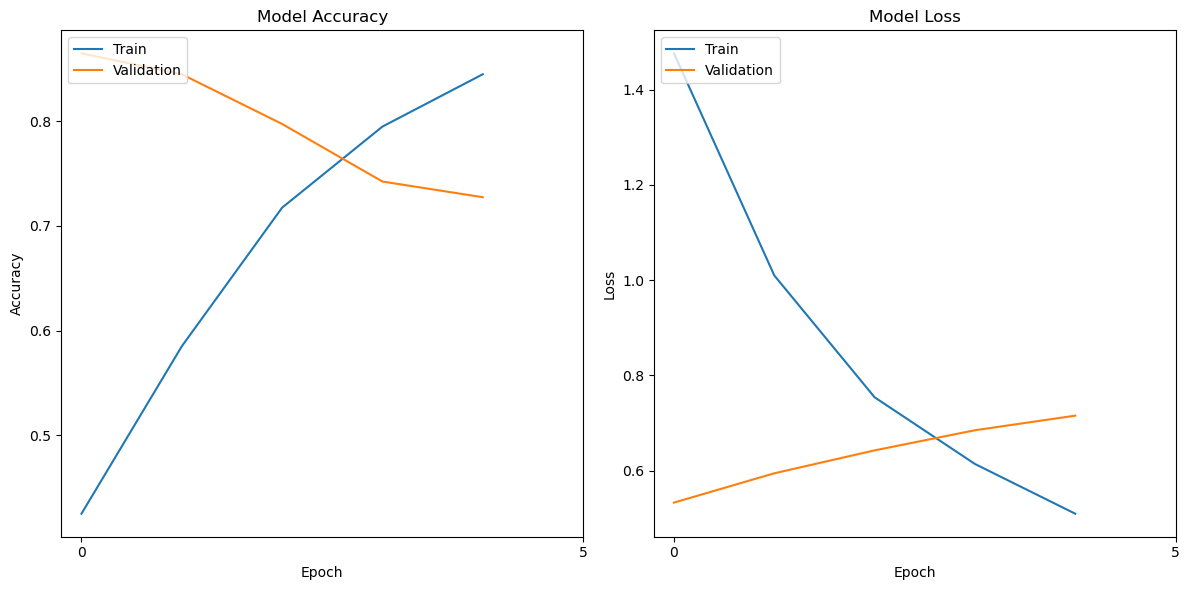

G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0Net_fold_1_training_history.json
G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0Net_fold_1_training_history.csv
G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0Net_fold_1_training_history.npy
7/7 [==============================] - 0s 3ms/step
y_pred [[3.16749007e-01 2.26765484e-01 2.56458014e-01 2.00027511e-01]
 [4.53167021e-01 1.99739128e-01 1.50019377e-01 1.97074518e-01]
 [9.59051073e-01 6.66318927e-03 2.84520052e-02 5.83379949e-03]
 [7.81370044e-01 1.04807995e-01 8.49472806e-02 2.88747605e-02]
 [1.81583777e-01 1.96769014e-01 1.51253775e-01 4.70393389e-01]
 [3.22824478e-01 9.23672616e-02 5.39853692e-01 4.49545160e-02]
 [7.64178395e-01 3.18017043e-02 1.83946460e-01 2.00733989e-02]
 [9.80513513e-01 2.39269299e-04 1.69554986e-02 2.2

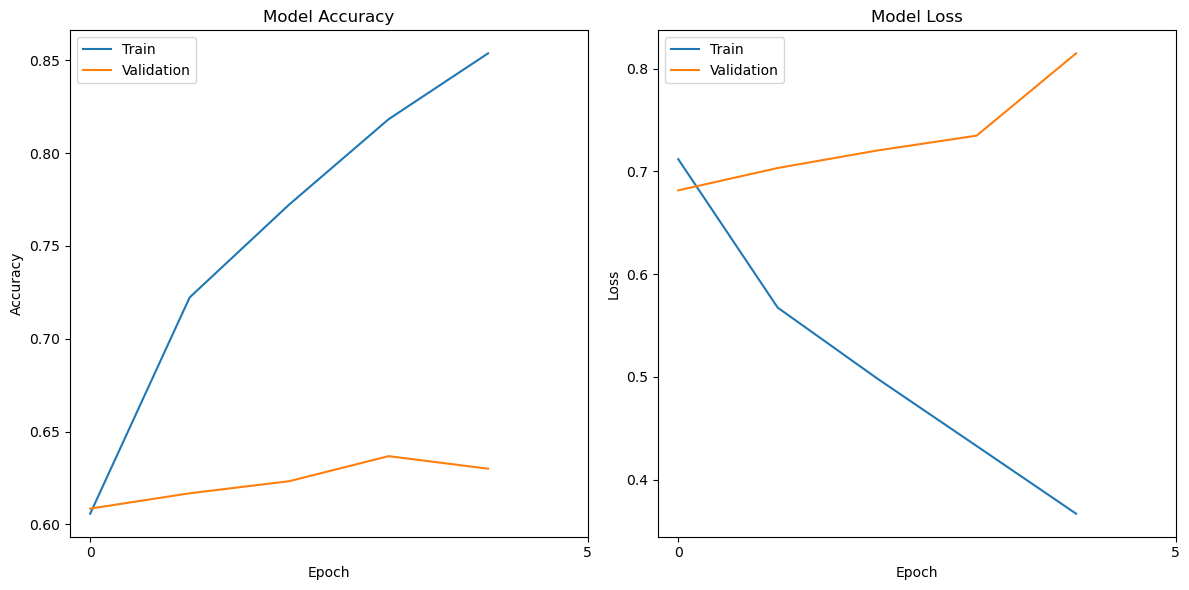

G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_10000_classifier_ElossNet_fold_0_training_history.json
G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_10000_classifier_ElossNet_fold_0_training_history.csv
G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_10000_classifier_ElossNet_fold_0_training_history.npy
63/63 [==============================] - 0s 3ms/step
y_pred [[0.33848456 0.63338107]
 [0.25328612 0.75118214]
 [0.19912261 0.8340736 ]
 ...
 [0.3259932  0.7080369 ]
 [0.16098    0.79719305]
 [0.89677626 0.07301638]]
Accuracy: 0.6335
Confusion Matrix: [[623 364]
 [369 644]]
Epoch 1/5
117/125 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.6477
Epoch 1: val_accuracy improved from -inf to 0.80275, saving model to G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size

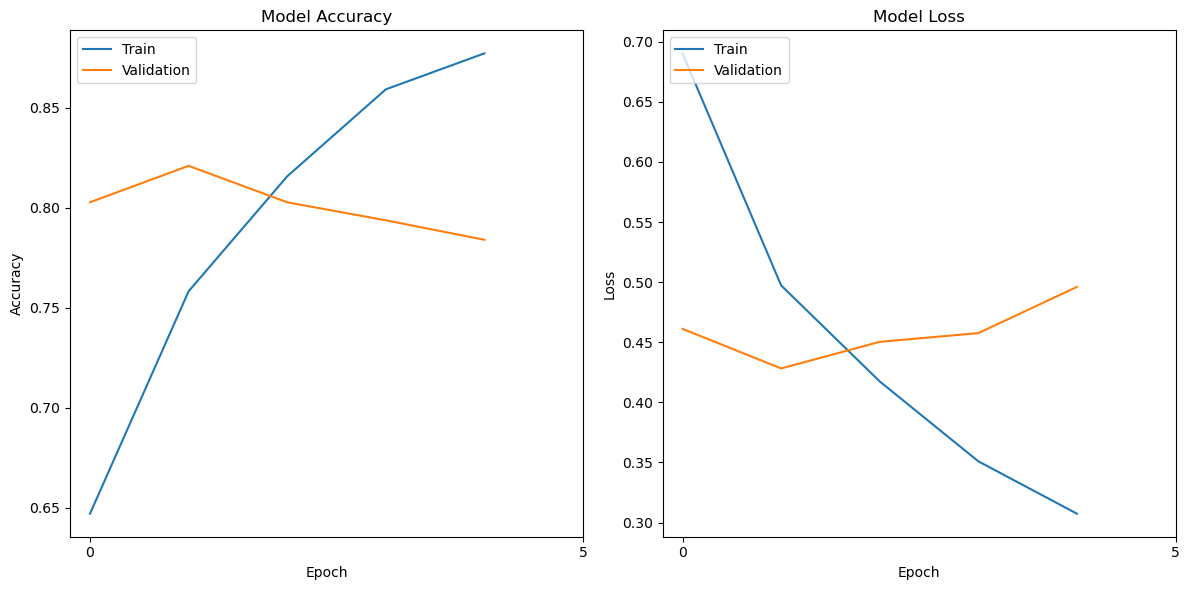

G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_10000_classifier_ElossNet_fold_1_training_history.json
G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_10000_classifier_ElossNet_fold_1_training_history.csv
G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_10000_classifier_ElossNet_fold_1_training_history.npy
63/63 [==============================] - 0s 4ms/step
y_pred [[0.09502868 0.88308877]
 [0.3523327  0.7527535 ]
 [0.07883956 0.9125088 ]
 ...
 [0.25048837 0.6257215 ]
 [0.20364946 0.85457164]
 [0.9692806  0.02968292]]
Accuracy: 0.691
Confusion Matrix: [[614 373]
 [245 768]]
Average Train Time: 0.08352389136950175 minutes
Average Train Time: 0.08352389136950175 minutes
G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_10000_classifier_AlphaSNet
Epoch 1/5
115/125 [======================

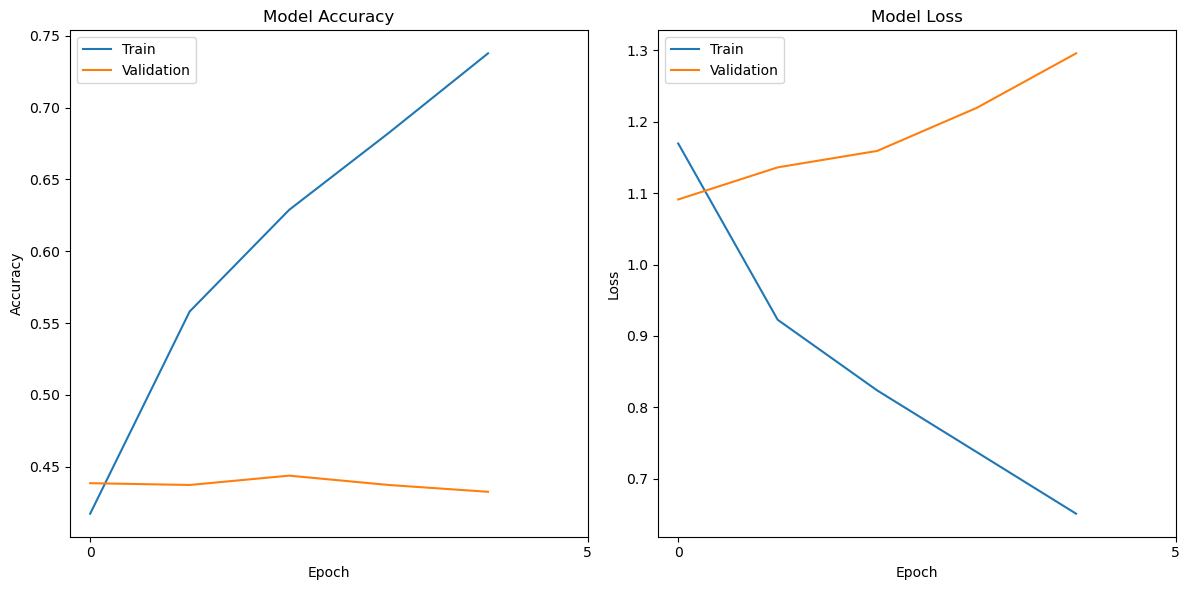

G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_10000_classifier_AlphaSNet_fold_0_training_history.json
G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_10000_classifier_AlphaSNet_fold_0_training_history.csv
G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_10000_classifier_AlphaSNet_fold_0_training_history.npy
63/63 [==============================] - 0s 3ms/step
y_pred [[0.32330805 0.08774977 0.58894217]
 [0.08333088 0.20169887 0.71497023]
 [0.3751024  0.4801468  0.1447508 ]
 ...
 [0.21478243 0.72852004 0.05669752]
 [0.06952466 0.07336322 0.85711217]
 [0.05539634 0.08018363 0.86442   ]]
Accuracy: 0.4405
Confusion Matrix: [[334 185 150]
 [210 228 242]
 [155 177 319]]
Epoch 1/5
118/125 [===========================>..] - ETA: 0s - loss: 1.1806 - accuracy: 0.4147
Epoch 1: val_accuracy improved from -inf to 0.68225, saving model to G:\My D

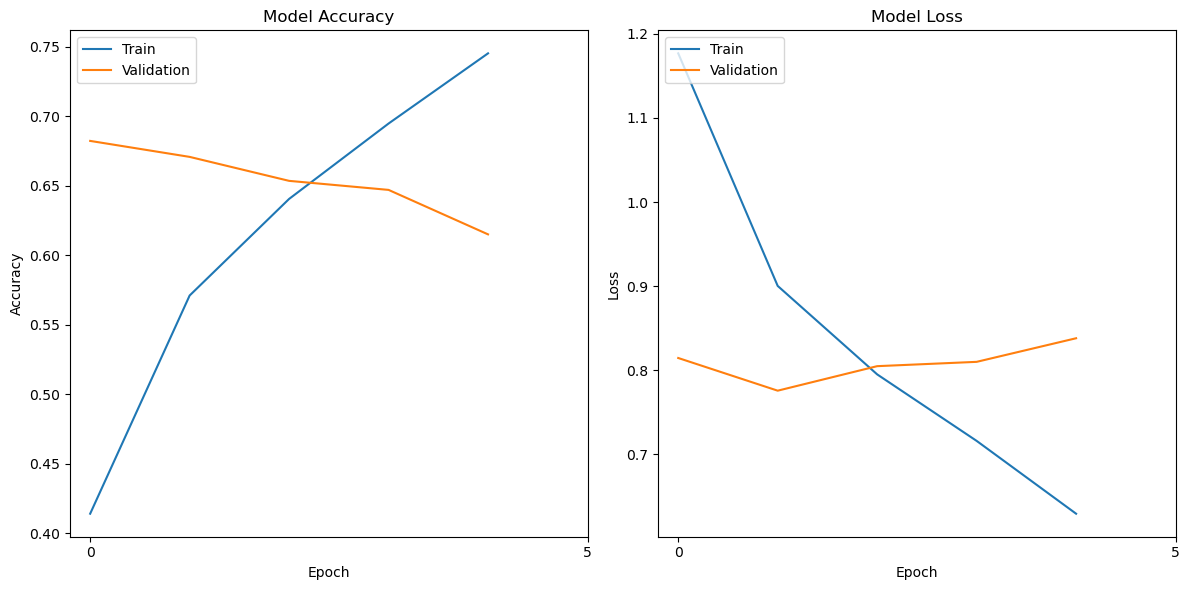

G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_10000_classifier_AlphaSNet_fold_1_training_history.json
G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_10000_classifier_AlphaSNet_fold_1_training_history.csv
G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_10000_classifier_AlphaSNet_fold_1_training_history.npy
63/63 [==============================] - 0s 3ms/step
y_pred [[0.22603616 0.5360465  0.2379174 ]
 [0.0377369  0.20237687 0.7598862 ]
 [0.39253244 0.41945845 0.18800908]
 ...
 [0.3350483  0.6142426  0.05070908]
 [0.2053504  0.09342083 0.7012288 ]
 [0.02568213 0.17935628 0.7949616 ]]
Accuracy: 0.407
Confusion Matrix: [[250 271 148]
 [181 242 257]
 [115 214 322]]
Average Train Time: 0.07850967645645142 minutes
Average Train Time: 0.07850967645645142 minutes
G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\je

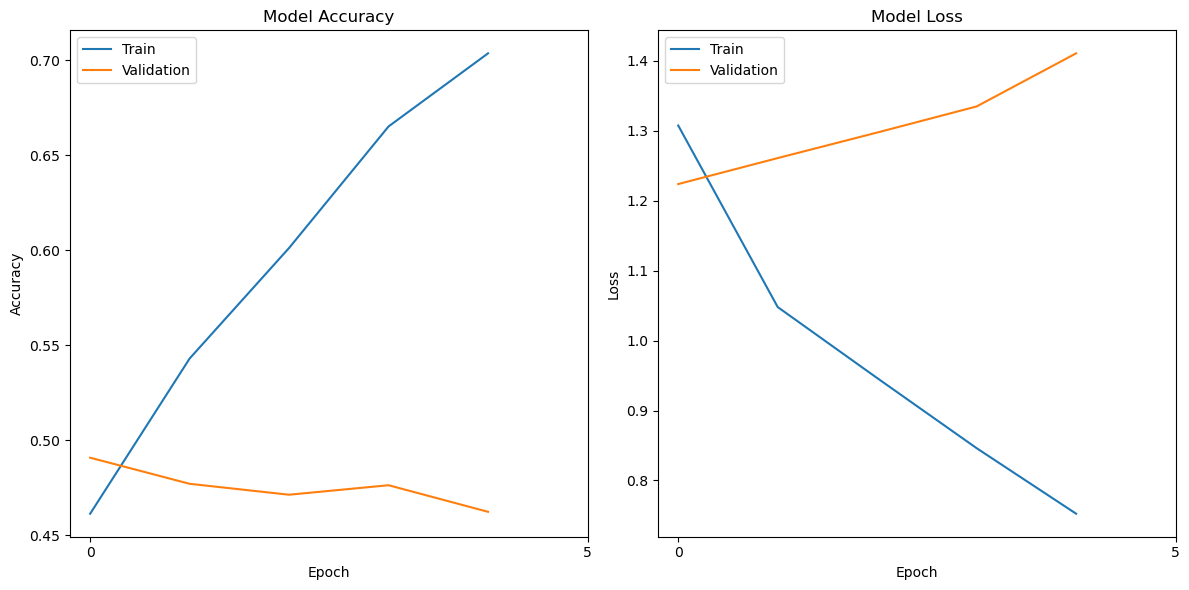

G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_10000_classifier_Q0Net_fold_0_training_history.json
G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_10000_classifier_Q0Net_fold_0_training_history.csv
G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_10000_classifier_Q0Net_fold_0_training_history.npy
63/63 [==============================] - 0s 3ms/step
y_pred [[0.5840895  0.11102974 0.04546321 0.25941762]
 [0.6233589  0.15294364 0.12920257 0.09449486]
 [0.7557664  0.0206172  0.07679916 0.14681727]
 ...
 [0.5674968  0.10042603 0.03442469 0.2976525 ]
 [0.88426965 0.06514058 0.01064375 0.03994599]
 [0.2227267  0.24109994 0.3507586  0.18541478]]
Accuracy: 0.483
Confusion Matrix: [[799  67  74  73]
 [170  56  52  54]
 [191  35  63  49]
 [179  47  43  48]]
Epoch 1/5
122/125 [============================>.] - ETA: 0s - loss: 1.2979 - accuracy:

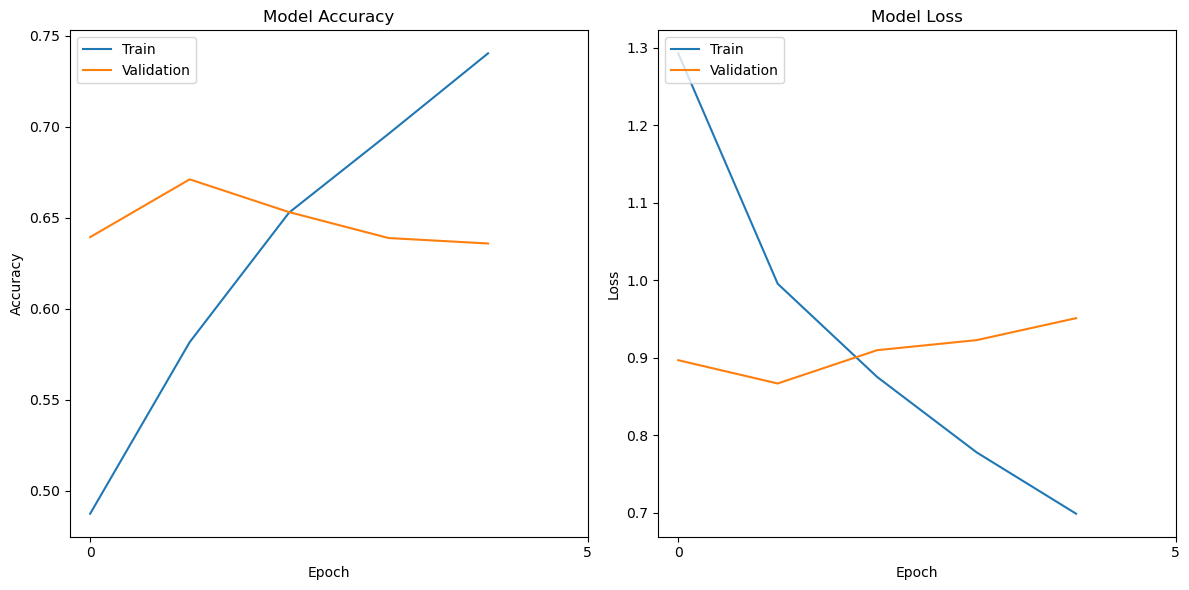

G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_10000_classifier_Q0Net_fold_1_training_history.json
G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_10000_classifier_Q0Net_fold_1_training_history.csv
G:\My Drive\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_10000_classifier_Q0Net_fold_1_training_history.npy
63/63 [==============================] - 0s 3ms/step
y_pred [[0.88849854 0.02431679 0.01427185 0.07291278]
 [0.73001915 0.07550644 0.12591411 0.06856026]
 [0.9362275  0.0142702  0.0238319  0.02567036]
 ...
 [0.7878315  0.0990463  0.01264627 0.10047596]
 [0.8824012  0.0883262  0.0148457  0.01442687]
 [0.07308902 0.32166028 0.2678744  0.33737627]]
Accuracy: 0.5185
Confusion Matrix: [[861  50  69  33]
 [182  42  69  39]
 [180  25  91  42]
 [146  42  86  43]]
Average Train Time: 0.07925536235173543 minutes
Average Train Time: 0.0792553623517354

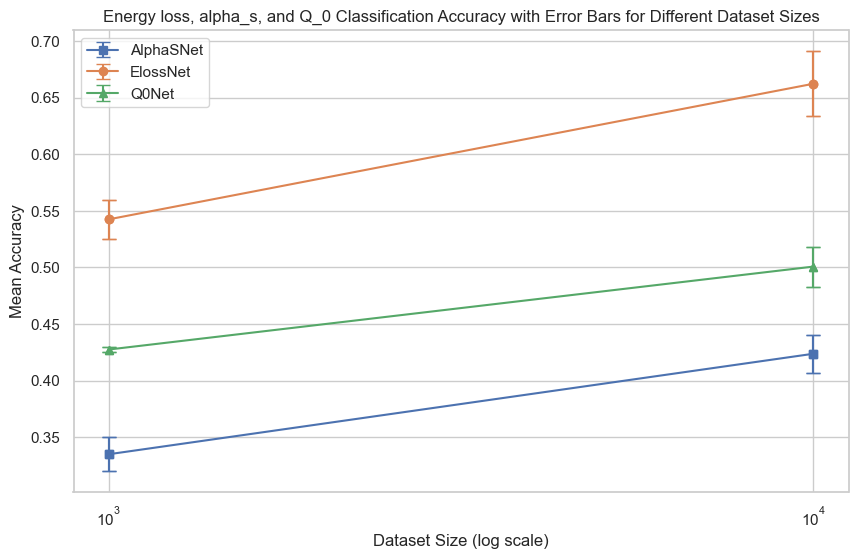

In [44]:
monitor = 'val_accuracy'  # 'val_accuracy' or 'val_loss'
n_epochs = 5
k_folds = 2  # You can adjust the number of folds

# defining dataset sizes and classifiers

# Sizes of datasets
# dataset_sizes = [1000]
# dataset_sizes = [100000]
# dataset_sizes = [1000000]
dataset_sizes = [1000, 10000]
#dataset_sizes = [1000, 10000,100000]
# dataset_sizes = [1000, 10000, 100000, 1000000]

print(simulation_directory_path)
# simulation_path=f'{simulation_directory_path}jetml_classification_{class_labels_str}'
simulation_path=f'{simulation_directory_path}jetml_classification'
train_and_evaluate_classifier_for_all_datasets(dataset_sizes,classifiers,simulation_path,n_epochs, monitor, k_folds)